In [51]:
import torch
from torch import nn,Tensor
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torchvision.transforms.functional import pil_to_tensor
import torch.nn.functional as F
from torch import optim
from monai.losses import DiceLoss
import os, json, math, time
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import os
import math 
import random
import itertools as itertools
from PIL import Image
from typing import Dict, Iterable, Optional, Sequence, Tuple, Union

In [52]:
TRAINING_PATHS = list(Path().glob("**/CamVid/train"))
TRAINING_LABELS_PATHS = list(Path().glob("**/CamVid/train_labels"))

VALIDATION_PATHS = list(Path().glob("**/CamVid/val"))
VALIDATION_LABELS_PATHS = list(Path().glob("**/CamVid/val_labels"))

TEST_PATHS = list(Path().glob("**/CamVid/test"))
TEST_LABELS_PATHS = list(Path().glob("**/CamVid/test_labels"))

COLORS_PATH = list(Path().glob("**/CamVid/class_dict.csv"))

## Understanding the data
- Before designing our model, we will study the data that will be fed to it.

In [53]:
# Ensure consistent ordering so that each training image is matched with its corresponding label image
t_img = sorted([str(p) for p in TRAINING_PATHS[0].glob("*.png")])
l_img = sorted([str(p) for p in TRAINING_LABELS_PATHS[0].glob("*.png")])

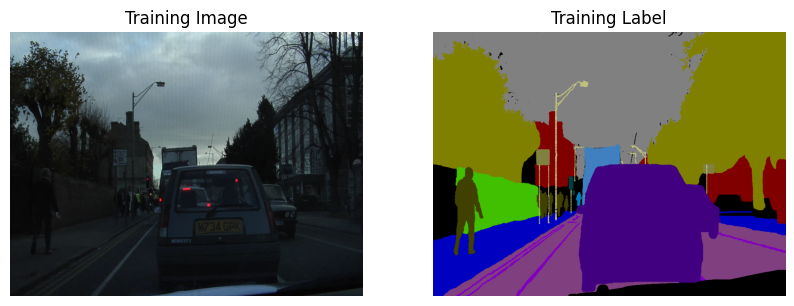

Image PIL size (Width and Height): (960, 720)
Mask PIL size: (960, 720)
Image tensor size:(Height and Width) torch.Size([3, 720, 960])
Mask tensor size: torch.Size([3, 720, 960])


In [54]:
train_sample,train_label_sample = Image.open(t_img[0]), Image.open(l_img[0])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training Image")
plt.imshow(train_sample)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Training Label")
plt.imshow(train_label_sample)
plt.axis("off")

plt.show()


img_tensor  = pil_to_tensor(train_sample)
mask_tensor = pil_to_tensor(train_label_sample)

print("Image PIL size (Width and Height):", train_sample.size)       
print("Mask PIL size:", train_label_sample.size)  
print("Image tensor size:(Height and Width)", img_tensor.shape)    
print("Mask tensor size:", mask_tensor.shape)    

Given the internal downsampling procedure used in the U-Net architecture, it is important that the image dimensions are divisible by $2^n$. 

We are for the largest integer $n$ such that:
$$
\frac{720}{2^n} \in\mathbb{Z}
$$
That would be $n=4$. Hence, we can downsample at most four times.

In [55]:
MAX_DOWNSAMPLING_DEPTH = 4
INPUT_CHANNEL = 3

To train our model for classification, we must establish a correspondence between the channel colors and the labels. Therefore, we will create a dictionary that encodes this mapping.

In [56]:
df = pd.read_csv(COLORS_PATH[0])
color2id = {
            (int(r), int(g), int(b)): class_id
            for class_id, (r, g, b) in enumerate(zip(df.r, df.g, df.b))
        }
color2id.keys()

dict_keys([(64, 128, 64), (192, 0, 128), (0, 128, 192), (0, 128, 64), (128, 0, 0), (64, 0, 128), (64, 0, 192), (192, 128, 64), (192, 192, 128), (64, 64, 128), (128, 0, 192), (192, 0, 64), (128, 128, 64), (192, 0, 192), (128, 64, 64), (64, 192, 128), (64, 64, 0), (128, 64, 128), (128, 128, 192), (0, 0, 192), (192, 128, 128), (128, 128, 128), (64, 128, 192), (0, 0, 64), (0, 64, 64), (192, 64, 128), (128, 128, 0), (192, 128, 192), (64, 0, 64), (192, 192, 0), (0, 0, 0), (64, 192, 0)])

## Creating the dataset

We will create a custom transformation to map each pixel value (RGB) to its respective class. To achieve this, our class will implement the `__call__` method so that it can behave like a function.

In [57]:
# a = np.array([[1,2,3],[4,5,6],[1,2,3],[4,5,6],[8,9,10]])
# print(f"all values:\n{a}")
# uniq, inv = np.unique(a,axis=0,return_inverse=True)
# print()
# print(f"unique values (rgb):\n{uniq}")
# print()
# print(f"mapping (collapsed rgb): \n{inv}")

#==============================================================================#

# rgb_np = np.array(train_sample,np.uint8)
# print(rgb_np.shape)
# H,W,_ = rgb_np.shape

# flat_rgb_np = rgb_np.reshape(-1,3)
# print(flat_rgb_np.shape)

# flat_np = np.zeros_like(flat_rgb_np[:,1].reshape(-1,1),dtype=np.uint8)
# print(flat_np.shape)

# # Finding unique rows and returning  index
# uniq, inv = np.unique(flat_rgb_np,axis=0,return_inverse=True)
# len(uniq), len(inv) == len(flat_rgb_np)

In [58]:
class MaskToClassIds:
    def __init__(self, color_id, ignore_index=None):
        self.color_id = color_id
        self.ignore_index = ignore_index
         
    def __call__(self, train_label_img):
        rgb_np = np.array(train_label_img, dtype=np.uint8)
        H, W, _ = rgb_np.shape

        flat_rgb_np = rgb_np.reshape(-1, 3)
        uniq, inv = np.unique(flat_rgb_np, axis=0, return_inverse=True)

        mapped = np.zeros(len(uniq), dtype=np.uint8)
        for i, (r, g, b) in enumerate(uniq):
            if (r, g, b) in self.color_id:
                mapped[i] = self.color_id[(r, g, b)]
            elif self.ignore_index is not None:
                mapped[i] = self.ignore_index

        label_mask = mapped[inv].reshape(H, W)
        return label_mask


class CamvidDataset(Dataset):
    def __init__(self, image_paths, mask_paths, color2id, image_transform=None):
        assert len(image_paths) == len(mask_paths), "Image/mask counts diferem."

        self.image_paths = image_paths
        self.image_transform = image_transform or transforms.ToTensor()
        self.mask_transform = MaskToClassIds(color2id)

        self.precomputed_masks = []
        for mp in mask_paths:
            mask = Image.open(mp).convert("RGB")
            label_np = self.mask_transform(mask)
            label_t = torch.from_numpy(label_np).long()
            self.precomputed_masks.append(label_t)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img = Image.open(self.image_paths[index]).convert("RGB")
        img_t = self.image_transform(img) if self.image_transform else img

        label_t = self.precomputed_masks[index]

        return img_t, label_t


In [59]:
train_dataset = CamvidDataset(
    image_paths=sorted([str(p) for p in TRAINING_PATHS[0].glob("*.png")]),
    mask_paths=sorted([str(p) for p in TRAINING_LABELS_PATHS[0].glob("*.png")]),
    color2id=color2id
)

In [60]:
val_dataset = CamvidDataset(
    image_paths=sorted([str(p) for p in VALIDATION_PATHS[0].glob("*.png")]),
    mask_paths=sorted([str(p) for p in VALIDATION_LABELS_PATHS[0].glob("*.png")]),
    color2id=color2id
)

In [61]:
# test_dataset = CamvidDataset(
#     image_paths=sorted([str(p) for p in TEST_PATHS[0].glob("*.png")]),
#     mask_paths=sorted([str(p) for p in TEST_LABELS_PATHS[0].glob("*.png")]),
#     color2id=color2id
# )

In [62]:
# img_t, label_t = train_dataset[0]
# print(type(img_t), img_t.shape)   
# print(type(label_t), label_t.shape, label_t.dtype)  

In [63]:
# loader = DataLoader(train_dataset, batch_size=8) 
# max_label = -1
# for _, labels in loader:
#     val = labels.max().item()
#     if val > max_label:
#         max_label = val

# print("Biggest Label Size", max_label)

## U-Net Architecture
- The main idea is: in each downsampling step, we halve the spatial dimensions (height and width) and double the number of channels in the encoder path.

- In the upsampling path, we do the opposite: we double the spatial dimensions and halve the number of channels.

First it is important to define all operations present in the architecture:

It is worth mentioning that we will deviate from the original paper implementation. First, we will use padding to preserve the input–output dimensions. In addition, we will disable the bias term in favor of using batch normalization, in order to guarantee stability during convergence.

https://stats.stackexchange.com/questions/482305/batch-normalization-and-the-need-for-bias-in-neural-networks

In [64]:
# Encoding Procedure:
class ConvBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int) -> None:
        super().__init__()
        def _gn(c: int):
            # choose a group count that divides channels for stability with batch=1
            for g in (8, 4, 2, 1):
                if c % g == 0:
                    return nn.GroupNorm(g, c)
            return nn.GroupNorm(1, c)
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=True),
            _gn(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=True),
            _gn(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
    
class Down(nn.Module):
    def __init__(self, in_ch: int, out_ch: int) -> None:
        super().__init__()
        self.conv = ConvBlock(in_ch, out_ch)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x: Tensor):
        skip = self.conv(x)
        pooled = self.pool(skip)
        return skip, pooled
    
class BottleNeck(nn.Module):
    def __init__(self, in_ch: int, out_ch: int) -> None:
        super().__init__()
        self.net = nn.Sequential(
            ConvBlock(in_ch, out_ch)
        )
    def forward(self, x):
        return self.net(x)

In [65]:

# x = torch.randn(1, 3, 720, 960)   

# up = nn.ConvTranspose2d(
#     in_channels=3,     
#     out_channels=3,   
#     kernel_size=2,     
#     stride=2,          
#     padding=0, 
#     output_padding=0
# )

# y = up(x)
# print("Input shape:", x.shape)
# print("Output shape:", y.shape)

In [66]:
# Decoder
class Up(nn.Module):
    def __init__(self, in_ch: int, skip_ch: int, out_ch: int) -> None:
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = ConvBlock(skip_ch + out_ch, out_ch)

    def forward(self, x: Tensor, x_skip: Tensor) -> Tensor:
        x = self.up(x)
        x = torch.cat([x_skip, x], dim=1)
        return self.conv(x)


In [67]:
class UNet(nn.Module):
    def __init__(self, num_classes: int, depth: int, in_channels: int = 3, width: int = 64) -> None:
        super().__init__()
        assert depth >= 1 and depth <= MAX_DOWNSAMPLING_DEPTH
        # widths[0], widths[1], ..., widths[depth-1]
        widths = [width * (2 ** i) for i in range(depth)]

        self.stem = ConvBlock(in_ch=in_channels, out_ch=widths[0])

        # encoder: each increases channels to widths[i+1]
        self.downs = nn.ModuleList([Down(widths[i], widths[i + 1]) for i in range(len(widths) - 1)])
        # bottleneck keeps channels = widths[-1]
        self.bottleneck = BottleNeck(widths[-1], widths[-1])

        # decoder: Up(in_ch=widths[i], out_ch=widths[i-1])
        self.ups = nn.ModuleList([Up(widths[i], widths[i], widths[i - 1]) for i in range(len(widths) - 1, 0, -1)])

        # final projection
        self.head = nn.Conv2d(widths[0], num_classes, kernel_size=1, bias=True)

    def forward(self, x: Tensor) -> Tensor:
        skips = []

        x = self.stem(x)  # channels = widths[0]

        # collect skips BEFORE pooling at each level
        for down in self.downs:
            s, x = down(x)     
            skips.append(s)

        x = self.bottleneck(x)
        x = self.bottleneck(x)

        for up in self.ups:
            skip = skips.pop()
            x = up(x, skip)

        logits = self.head(x)
        return logits

In [68]:
C, H, W = 3, 720, 960
num_classes = 12
depth = 4        
width = 32

img_t = torch.randn(C, H, W)
label_t = torch.randint(0, num_classes, (H, W), dtype=torch.int64)

x = img_t.unsqueeze(0)  # [1,3,720,960]
model = UNet(num_classes=num_classes, depth=depth, in_channels=C, width=width)

with torch.no_grad():
    logits = model(x)

print("Input shape :", tuple(x.shape))
print("Logits shape:", tuple(logits.shape))

criterion = nn.CrossEntropyLoss()
loss = criterion(logits, label_t.unsqueeze(0))
print("Loss (synthetic):", float(loss))

assert logits.shape[2:] == (H, W), "Spatial size mismatch."
assert logits.shape[1] == num_classes, "Channel count (num_classes) mismatch."
assert label_t.dtype == torch.int64, "Target dtype must be int64 for CrossEntropyLoss."
print("Assertions passed: UNet forward + CE loss are shape/dtype consistent.")


Input shape : (1, 3, 720, 960)
Logits shape: (1, 12, 720, 960)
Loss (synthetic): 2.550428867340088
Assertions passed: UNet forward + CE loss are shape/dtype consistent.


In [69]:
# Encoding Procedure:
class ConvBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int) -> None:
        super().__init__()
        def _gn(c: int):
            # choose a group count that divides channels for stability with batch=1
            for g in (8, 4, 2, 1):
                if c % g == 0:
                    return nn.GroupNorm(g, c)
            return nn.GroupNorm(1, c)
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=True),
            _gn(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=True),
            _gn(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
    
class Down(nn.Module):
    def __init__(self, in_ch: int, out_ch: int) -> None:
        super().__init__()
        self.conv = ConvBlock(in_ch, out_ch)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x: Tensor):
        skip = self.conv(x)
        pooled = self.pool(skip)
        return skip, pooled
    
class BottleNeck(nn.Module):
    def __init__(self, in_ch: int, out_ch: int) -> None:
        super().__init__()
        self.net = nn.Sequential(
            ConvBlock(in_ch, out_ch)
        )
    def forward(self, x):
        return self.net(x)
    

    # Decoder
class Up(nn.Module):
    def __init__(self, in_ch: int, skip_ch: int, out_ch: int) -> None:
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = ConvBlock(skip_ch + out_ch, out_ch)

    def forward(self, x: Tensor, x_skip: Tensor) -> Tensor:
        x = self.up(x)
        x = torch.cat([x_skip, x], dim=1)
        return self.conv(x)
class UNet(nn.Module):
    def __init__(self, num_classes: int, depth: int, in_channels: int = 3, width: int = 64) -> None:
        super().__init__()
        assert depth >= 1 and depth <= MAX_DOWNSAMPLING_DEPTH
        # widths[0], widths[1], ..., widths[depth-1]
        widths = [width * (2 ** i) for i in range(depth)]

        self.stem = ConvBlock(in_ch=in_channels, out_ch=widths[0])

        # encoder: each increases channels to widths[i+1]
        self.downs = nn.ModuleList([Down(widths[i], widths[i + 1]) for i in range(len(widths) - 1)])
        # bottleneck keeps channels = widths[-1]
        self.bottleneck = BottleNeck(widths[-1], widths[-1])

        # decoder: Up(in_ch=widths[i], out_ch=widths[i-1])
        self.ups = nn.ModuleList([Up(widths[i], widths[i], widths[i - 1]) for i in range(len(widths) - 1, 0, -1)])

        # final projection
        self.head = nn.Conv2d(widths[0], num_classes, kernel_size=1, bias=True)

    def forward(self, x: Tensor) -> Tensor:
        skips = []

        x = self.stem(x)  # channels = widths[0]

        # collect skips BEFORE pooling at each level
        for down in self.downs:
            s, x = down(x)     
            skips.append(s)

        x = self.bottleneck(x)
        x = self.bottleneck(x)

        for up in self.ups:
            skip = skips.pop()
            x = up(x, skip)

        logits = self.head(x)
        return logits

## Training
- When using multiclass, we don't need to know a priori the mapping between label indices and output channels. The network should learn this.

In [70]:
SEED = 22
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

device = get_device()
device

device(type='mps')

In [71]:
depths = (3,)
learning_rates = (1e-3, 3e-4, 1e-4)
optimizers = ("adam",)
epochs = (30,)
initial_widths = (32,)
loss_funcs = ("cross_entropy",)
batch_size = 1

grid = list(itertools.product(
    depths,
    learning_rates,
    optimizers,
    epochs,
    initial_widths,
    loss_funcs
))

print(f"Total configs: {len(grid)}")

Total configs: 3


In [72]:
configs = [
    {
        "depth": d,
        "lr": lr,
        "optimizer": opt,
        "epochs": ep,
        "width": w,
        "loss": lf,
    }
    for d, lr, opt, ep, w, lf in grid
]

print("Configs:", configs)

Configs: [{'depth': 3, 'lr': 0.001, 'optimizer': 'adam', 'epochs': 30, 'width': 32, 'loss': 'cross_entropy'}, {'depth': 3, 'lr': 0.0003, 'optimizer': 'adam', 'epochs': 30, 'width': 32, 'loss': 'cross_entropy'}, {'depth': 3, 'lr': 0.0001, 'optimizer': 'adam', 'epochs': 30, 'width': 32, 'loss': 'cross_entropy'}]


In [73]:
# Optimal MPS configs
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,   
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

In [74]:
def make_optimizer(opt_name, model, lr):
    if opt_name == "adam":
        return torch.optim.Adam(model.parameters(), lr=lr)
    if opt_name == "sgd_nesterov":
        return torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    raise ValueError(opt_name)


def make_loss(loss_name):
    if loss_name == "cross_entropy":
        return nn.CrossEntropyLoss()
    if loss_name == "dice_loss":
        return DiceLoss(
            to_onehot_y=True,   # targets are class indices [N,H,W]
            softmax=True        # outputs raw logits [N,C,H,W]
        )
    raise ValueError(loss_name)

In [75]:
import torch

def run_experiment(cfg, UNet, train_loader, val_loader, num_classes, ignore_index: int | None = None):
    depth, width   = cfg["depth"], cfg["width"]
    lr, opt_name   = cfg["lr"], cfg["optimizer"]
    epochs         = cfg["epochs"]
    loss_name      = cfg["loss"]

    model = UNet(in_channels=INPUT_CHANNEL, depth=depth, num_classes=num_classes, width=width).to(device)
    optimizer = make_optimizer(opt_name, model, lr)
    criterion = make_loss(loss_name)

    for epoch in range(1, epochs + 1):
        # ---------------------- Train ----------------------
        model.train()
        train_loss = 0.0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device).long()
            y_in = y.unsqueeze(1) if loss_name == 'dice_loss' else y

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits.float(), y_in)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)
        train_loss /= len(train_loader.dataset)

        # ---------------------- Validate ----------------------
        model.eval()
        val_loss = 0.0
        val_pix_correct = 0.0
        val_pix_total = 0

        # For IoU: confusion matrix C where C[g, p] counts pixels with gt=g and pred=p
        C = torch.zeros((num_classes, num_classes), dtype=torch.long, device=device)

        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device).long()
                y_in = y.unsqueeze(1) if loss_name == 'dice_loss' else y

                logits = model(x)
                loss = criterion(logits.float(), y_in)
                val_loss += loss.item() * x.size(0)

                preds = logits.argmax(dim=1)  # (B,H,W)

                # Pixel accuracy
                if ignore_index is not None:
                    mask = (y != ignore_index)
                    val_pix_correct += (preds.eq(y) & mask).sum().item()
                    val_pix_total   += mask.sum().item()
                else:
                    val_pix_correct += preds.eq(y).sum().item()
                    val_pix_total   += y.numel()

                # Confusion matrix accumulation for IoU
                if ignore_index is not None:
                    y_flat = y[mask].view(-1)
                    p_flat = preds[mask].view(-1)
                else:
                    y_flat = y.view(-1)
                    p_flat = preds.view(-1)

                # Guard against empty after masking
                if y_flat.numel() > 0:
                    k = num_classes
                    inds = (y_flat * k + p_flat).view(-1)
                    C += torch.bincount(inds, minlength=k*k).view(k, k)

        val_loss   /= len(val_loader.dataset)
        val_pix_acc = val_pix_correct / max(1, val_pix_total)

        # IoU computation
        C_float = C.float()
        tp = torch.diag(C_float)                     # per-class true positives
        fp = C_float.sum(dim=0) - tp                 # predicted as class but not gt
        fn = C_float.sum(dim=1) - tp                 # gt of class but predicted other
        denom = tp + fp + fn
        valid = denom > 0
        eps = 1e-7
        iou_per_class = torch.zeros(num_classes, device=device)
        iou_per_class[valid] = tp[valid] / (denom[valid] + eps)
        miou = iou_per_class[valid].mean().item() if valid.any() else float('nan')

        # Print summary (per-class IoU as a short vector)
        iou_list = ", ".join([f"{c}:{iou_per_class[c].item():.3f}" for c in range(num_classes)])
        print(
            f"[Config: depth={depth}, width={width}, lr={lr}, opt={opt_name}, loss={loss_name}] "
            f"Epoch {epoch:03d} | Train Loss {train_loss:.6f} | Val Loss {val_loss:.6f} | "
            f"Val pix_acc {val_pix_acc:.3f} | mIoU {miou:.3f} | IoU per class [{iou_list}]"
        )
    

In [76]:
PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.7 ./webui.sh --precision full --no-half

SyntaxError: invalid syntax (2653796536.py, line 1)

In [ ]:
for cfg in configs:
    run_experiment(cfg, UNet, train_loader, val_loader, num_classes=len(color2id.keys()))

RuntimeError: MPS backend out of memory (MPS allocated: 17.85 GB, other allocations: 2.81 MB, max allowed: 18.13 GB). Tried to allocate 675.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).